Baseado em:

Transfer Learning for Computer Vision Tutorial
</br>
https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

# Instalando bibliotecas e importando as bibliotecas necessárias para este notebook.

In [1]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118, https://pypi.ngc.nvidia.com


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
import time

cudnn.benchmark = True
plt.ion()   # interactive mode

In [4]:
torch.cuda.is_available()

True

In [5]:
torch.version.cuda

'11.8'

In [6]:
device0 = torch.device("cuda:0")
device0

device(type='cuda', index=0)

In [7]:
torch.cuda.get_device_name(device=device0)

'NVIDIA GeForce RTX 2060 SUPER'

# Carregando e processando as imagens do dataset

In [9]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# data_dir = '../dataset/dataset_cerradov3_1k_300'
data_dir = '../dataset/dataset_cerradov3_300_300'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Visualizando algumas imagens do dataset

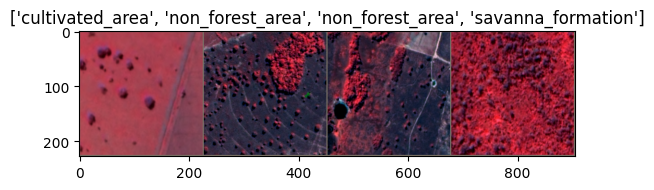

In [10]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Função para treinar o modelo

In [11]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

# Fine-Tuning do modelo pré-treinado

In [12]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
# model_ft = models.resnet50(weights='IMAGENET1K_V2')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
# model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Função para visualizar as predições do modelo

In [13]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            # for label in labels:
            #     print(class_names[label])

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                # ax.set_title(f'predicted: {class_names[preds[j]]}')
                ax.set_title(f'ground truth: {class_names[labels[j]]} \n predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# Exemplos de predições do modelo pré-treinado

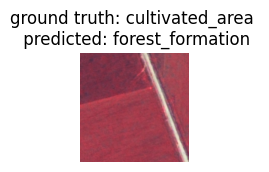

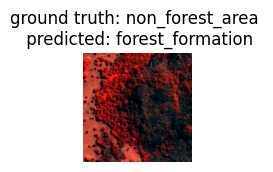

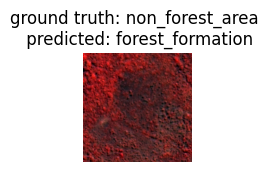

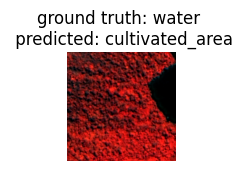

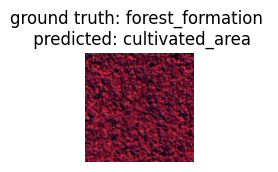

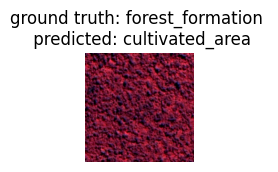

In [14]:
visualize_model(model_ft)

# Treinando (fine-tuning) e visualizando as predições do modelo

In [15]:
model_ft = train_model(model_ft, 
                       criterion, 
                       optimizer_ft, 
                       exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------
train Loss: 0.9900 Acc: 0.6433
val Loss: 0.8725 Acc: 0.7040

Epoch 1/9
----------
train Loss: 0.6618 Acc: 0.7840
val Loss: 0.5486 Acc: 0.8233

Epoch 2/9
----------
train Loss: 0.6211 Acc: 0.7960
val Loss: 0.6149 Acc: 0.7853

Epoch 3/9
----------
train Loss: 0.5881 Acc: 0.8213
val Loss: 0.6629 Acc: 0.7647

Epoch 4/9
----------
train Loss: 0.5003 Acc: 0.8473
val Loss: 1.0330 Acc: 0.6947

Epoch 5/9
----------
train Loss: 0.4593 Acc: 0.8560
val Loss: 0.9397 Acc: 0.7807

Epoch 6/9
----------
train Loss: 0.4526 Acc: 0.8567
val Loss: 0.8984 Acc: 0.7047

Epoch 7/9
----------
train Loss: 0.3403 Acc: 0.8873
val Loss: 0.5568 Acc: 0.8100

Epoch 8/9
----------
train Loss: 0.2650 Acc: 0.9267
val Loss: 0.4959 Acc: 0.8313

Epoch 9/9
----------
train Loss: 0.2518 Acc: 0.9200
val Loss: 0.5452 Acc: 0.8120

Training complete in 7m 41s
Best val Acc: 0.831333


# Exemplos de predições do modelo treinado (fine-tuning)

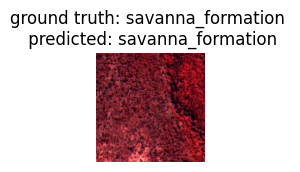

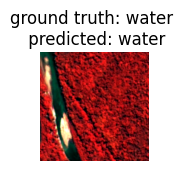

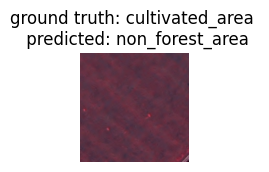

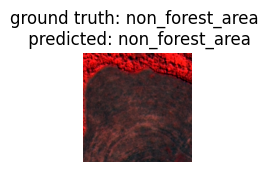

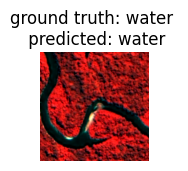

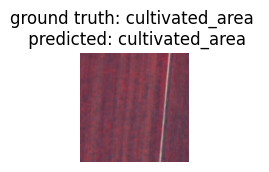

In [16]:
visualize_model(model_ft)

# Logits e seleção da categoria mais provável

In [28]:
outputs = None
_, preds = None, None

# Iterate over data.
for inputs, labels in dataloaders['val']:
    inputs = inputs.to(device)
    labels = labels.to(device)

    # zero the parameter gradients
    optimizer_ft.zero_grad()

    # forward
    # track history if only in train
    outputs = model_ft(inputs)
    _, preds = torch.max(outputs, 1)

print(f'outputs: {outputs}')
print(f'preds: {preds}')

outputs: tensor([[ -5.1604,  13.2930, -10.6957,   2.6599,  -2.1604],
        [ -3.8657,   4.6618,  -3.9878,   3.6144,  -2.3550],
        [ -8.2397,  -5.7257,   6.2228,   3.2302,   4.0926],
        [ -3.4358,   0.0988,   1.4523,   1.7505,  -0.1944]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
preds: tensor([1, 1, 2, 3], device='cuda:0')


<!-- # Explicabilidade -->

<!-- ## Instalação da biblioteca TorchCAM

Github:
</br>
https://github.com/frgfm/torch-cam
</br>
</br>
Documentação:
</br>
https://frgfm.github.io/torch-cam/index.html -->